# Description

This notebooks analyzes more closely the pattern between gene pair *UTY* / *KDM6A*. The analyses are focused on the Reviewer 2's comment:

```
In Figure 4, while there is a visible difference between the correlation of male samples, the CCC values are still quite close. For example, this can be observed in Brain Cerebellum and Small Intestine Terminal Ileum. Please address this.
```

# Modules

In [1]:
import pandas as pd

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from ccc import conf
from ccc.coef import ccc

# Settings

In [2]:
# this gene pair was originally found with ccc on whole blood
# interesting: https://clincancerres.aacrjournals.org/content/26/21/5567.figures-only
gene0_id, gene1_id = "ENSG00000147050.14", "ENSG00000183878.15"
gene0_symbol, gene1_symbol = "KDM6A", "UTY"

# Paths

In [3]:
TISSUE_DIR = conf.GTEX["DATA_DIR"] / "data_by_tissue"
assert TISSUE_DIR.exists()

In [4]:
OUTPUT_FIGURE_DIR = (
    conf.MANUSCRIPT["FIGURES_DIR"]
    / "coefs_comp"
    / f"{gene0_symbol.lower()}_vs_{gene1_symbol.lower()}"
)
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty')

# Data

## GTEx metadata

In [5]:
gtex_metadata = pd.read_pickle(conf.GTEX["DATA_DIR"] / "gtex_v8-sample_metadata.pkl")

In [6]:
gtex_metadata.shape

(22951, 66)

In [7]:
gtex_metadata.head()

,SUBJID,SEX,AGE,DTHHRDY,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0003-SM-58Q7G,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-5DWSB,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-6WBT7,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10a-SM-AHZ7F,GTEX-1117F,Female,60-69,4.0,NaN,"B1, A1",NaN,NaN,Brain,Brain - Frontal Cortex (BA9),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10b-SM-CYKQ8,GTEX-1117F,Female,60-69,4.0,NaN,"B1, A1",NaN,7.2,Brain,Brain - Frontal Cortex (BA9),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Gene Ensembl ID -> Symbol mapping

In [8]:
gene_map = pd.read_pickle(conf.GTEX["DATA_DIR"] / "gtex_gene_id_symbol_mappings.pkl")

In [9]:
gene_map = gene_map.set_index("gene_ens_id")["gene_symbol"].to_dict()

In [10]:
assert gene_map["ENSG00000145309.5"] == "CABS1"

In [11]:
assert gene_map[gene0_id] == gene0_symbol
assert gene_map[gene1_id] == gene1_symbol

## Get male/females sample IDs

In [12]:
gtex_metadata["SEX"].describe()

count     22951
unique        2
top        Male
freq      15046
Name: SEX, dtype: object

In [13]:
male_samples = gtex_metadata[gtex_metadata["SEX"] == "Male"].index.tolist()

In [14]:
len(male_samples)

15046

In [15]:
male_samples[:5]

['GTEX-111CU-0003-SM-58Q95',
 'GTEX-111CU-0003-SM-5DWTR',
 'GTEX-111CU-0003-SM-6WBUD',
 'GTEX-111CU-0126-SM-5GZWZ',
 'GTEX-111CU-0226-SM-5GZXC']

In [16]:
female_samples = gtex_metadata[gtex_metadata["SEX"] == "Female"].index.tolist()

In [17]:
len(female_samples)

7905

In [18]:
female_samples[:5]

['GTEX-1117F-0003-SM-58Q7G',
 'GTEX-1117F-0003-SM-5DWSB',
 'GTEX-1117F-0003-SM-6WBT7',
 'GTEX-1117F-0011-R10a-SM-AHZ7F',
 'GTEX-1117F-0011-R10b-SM-CYKQ8']

# Brain cerebellum

In [19]:
brain_cerebellum = (
    pd.read_pickle(TISSUE_DIR / "gtex_v8_data_brain_cerebellum.pkl")
    .loc[[gene0_id, gene1_id]]
    .T.rename_axis("sample_id")
)

In [20]:
brain_cerebellum.shape

(241, 2)

In [21]:
brain_cerebellum.head()

gene_ens_id,ENSG00000147050.14,ENSG00000183878.15
sample_id,,
GTEX-111FC-3326-SM-5GZYV,9.268,6.988
GTEX-1128S-2826-SM-5N9DI,12.930,0.000
GTEX-117XS-3126-SM-5GIDP,10.840,7.389
GTEX-1192X-3226-SM-5987D,10.780,5.132
GTEX-11DXW-1026-SM-5H11K,10.060,7.823


In [22]:
brain_cerebellum_males = brain_cerebellum.loc[
    brain_cerebellum.index.intersection(male_samples)
]

In [23]:
brain_cerebellum_males.shape

(174, 2)

In [24]:
brain_cerebellum_females = brain_cerebellum.loc[
    brain_cerebellum.index.intersection(female_samples)
]

In [25]:
brain_cerebellum_females.shape

(67, 2)

# Small intestine (terminal ileum)

In [26]:
small_intestine = (
    pd.read_pickle(TISSUE_DIR / "gtex_v8_data_small_intestine_terminal_ileum.pkl")
    .loc[[gene0_id, gene1_id]]
    .T.rename_axis("sample_id")
)

In [27]:
small_intestine.shape

(187, 2)

In [28]:
small_intestine.head()

gene_ens_id,ENSG00000147050.14,ENSG00000183878.15
sample_id,,
GTEX-111CU-1326-SM-5NQ8L,7.586,4.0370
GTEX-111YS-1426-SM-5GID8,13.500,3.3700
GTEX-1122O-1326-SM-5H11F,21.680,0.0309
GTEX-117YX-0326-SM-5GICL,8.964,5.2350
GTEX-1192X-2526-SM-59868,10.010,6.3990


In [29]:
small_intestine_males = small_intestine.loc[
    small_intestine.index.intersection(male_samples)
]

In [30]:
small_intestine_males.shape

(120, 2)

In [31]:
small_intestine_females = small_intestine.loc[
    small_intestine.index.intersection(female_samples)
]

In [32]:
small_intestine_females.shape

(67, 2)

# Compute correlation

## Brain cerebellum

### CCC

In [33]:
ccc(brain_cerebellum_males, pvalue_n_perms=1000)

(0.3674627535203262, 0.000999000999000999)

In [34]:
ccc(brain_cerebellum_females, pvalue_n_perms=1000)

(0.10427807486631016, 0.013986013986013986)

### Pearson

In [35]:
pearsonr(brain_cerebellum_males.iloc[:, 0], brain_cerebellum_males.iloc[:, 1])

(0.8570928082720543, 2.0135444417639445e-51)

In [36]:
pearsonr(brain_cerebellum_females.iloc[:, 0], brain_cerebellum_females.iloc[:, 1])

(0.21500691975584293, 0.08058770847518525)

### Spearman

In [37]:
spearmanr(brain_cerebellum_males.iloc[:, 0], brain_cerebellum_males.iloc[:, 1])

SpearmanrResult(correlation=0.7909406514931421, pvalue=1.5562774794999233e-38)

In [38]:
spearmanr(brain_cerebellum_females.iloc[:, 0], brain_cerebellum_females.iloc[:, 1])

SpearmanrResult(correlation=0.2225445085313031, pvalue=0.07028065513936946)

## Small intestine (terminal ileum)

### CCC

In [39]:
ccc(small_intestine_males, pvalue_n_perms=1000)

(0.13137865911237015, 0.000999000999000999)

In [40]:
ccc(small_intestine_females, pvalue_n_perms=1000)

(0.04191990815775257, 0.36563436563436563)

### Pearson

In [41]:
pearsonr(small_intestine_males.iloc[:, 0], small_intestine_males.iloc[:, 1])

(0.5401927091270222, 1.918887071018949e-10)

In [42]:
pearsonr(small_intestine_females.iloc[:, 0], small_intestine_females.iloc[:, 1])

(-0.12377555020943821, 0.3183161563369864)

### Spearman

In [43]:
spearmanr(small_intestine_males.iloc[:, 0], small_intestine_males.iloc[:, 1])

SpearmanrResult(correlation=0.46555777415724725, pvalue=8.417733469299811e-08)

In [44]:
spearmanr(small_intestine_females.iloc[:, 0], small_intestine_females.iloc[:, 1])

SpearmanrResult(correlation=0.1041356321278035, pvalue=0.40167737622824995)

# Compute correlation on all tissues, males only

In [45]:
res_all_males = pd.DataFrame(
    {
        f.stem.split("_data_")[1]: {
            "ccc": ccc(data[gene0_id], data[gene1_id]),
            "pearson": pearsonr(data[gene0_id], data[gene1_id])[0],
            "spearman": spearmanr(data[gene0_id], data[gene1_id])[0],
        }
        for f in TISSUE_DIR.glob("*.pkl")
        if (
            data := pd.read_pickle(f)
            .T[[gene0_id, gene1_id]]
            .reindex(male_samples)
            .dropna()
        )
        is not None
        and data.shape[0] > 10
    }
).T.abs()

In [46]:
res_all_males.shape

(47, 3)

In [47]:
res_all_males.head()

,ccc,pearson,spearman
colon_transverse,0.237485,0.704703,0.691430
brain_amygdala,0.540782,0.880306,0.914251
artery_coronary,0.410458,0.861073,0.801901
artery_aorta,0.428166,0.814962,0.810471
adrenal_gland,0.261443,0.657966,0.682019


In [48]:
res_all_males.sort_values("ccc")

,ccc,pearson,spearman
small_intestine_terminal_ileum,0.131379,0.540193,0.465558
stomach,0.186605,0.546008,0.631823
liver,0.189274,0.619830,0.618370
muscle_skeletal,0.205450,0.648536,0.658019
testis,0.206704,0.692661,0.690990
pituitary,0.217599,0.629830,0.643730
colon_transverse,0.237485,0.704703,0.691430
thyroid,0.255240,0.675918,0.697297
adrenal_gland,0.261443,0.657966,0.682019
colon_sigmoid,0.301971,0.784019,0.769884


In [49]:
res_all_males.sort_values("pearson")

,ccc,pearson,spearman
small_intestine_terminal_ileum,0.131379,0.540193,0.465558
stomach,0.186605,0.546008,0.631823
liver,0.189274,0.619830,0.618370
pituitary,0.217599,0.629830,0.643730
muscle_skeletal,0.205450,0.648536,0.658019
adrenal_gland,0.261443,0.657966,0.682019
thyroid,0.255240,0.675918,0.697297
testis,0.206704,0.692661,0.690990
colon_transverse,0.237485,0.704703,0.691430
cells_cultured_fibroblasts,0.434682,0.772410,0.791284


In [50]:
res_all_males.sort_values("spearman")

,ccc,pearson,spearman
small_intestine_terminal_ileum,0.131379,0.540193,0.465558
liver,0.189274,0.619830,0.618370
stomach,0.186605,0.546008,0.631823
pituitary,0.217599,0.629830,0.643730
muscle_skeletal,0.205450,0.648536,0.658019
adrenal_gland,0.261443,0.657966,0.682019
testis,0.206704,0.692661,0.690990
colon_transverse,0.237485,0.704703,0.691430
thyroid,0.255240,0.675918,0.697297
lung,0.383148,0.777688,0.767171


# Plot of male samples

In [51]:
def get_tissue_file(name):
    """
    Given a part of a tissue name, it returns a file path to the
    expression data for that tissue in GTEx. It fails if more than
    one files are found.

    Args:
        name: a string with the tissue name (or a part of it).

    Returns:
        A Path object pointing to the gene expression file for the
        given tissue.
    """
    tissue_files = []
    for f in TISSUE_DIR.glob("*.pkl"):
        if name in f.name:
            tissue_files.append(f)

    assert len(tissue_files) == 1
    return tissue_files[0]

In [52]:
# testing
_tmp = get_tissue_file("whole_blood")
assert _tmp.exists()

In [53]:
def simplify_tissue_name(tissue_name):
    return f"{tissue_name[0].upper()}{tissue_name[1:].replace('_', ' ')}"

In [54]:
assert simplify_tissue_name("whole_blood") == "Whole blood"
assert simplify_tissue_name("uterus") == "Uterus"

In [55]:
def plot_gene_pair(
    tissue_name,
    gene0,
    gene1,
    hue=None,
    kind="hex",
    ylim=None,
    bins="log",
    samples=None,
    filename_suffix="",
    tissue_name_in_title=None,
):
    """
    It plots (joint plot) a gene pair from the given tissue. It saves the plot
    for the manuscript.
    """
    # merge gene expression with metadata
    tissue_file = get_tissue_file(tissue_name)
    if samples is not None:
        tissue_data = (
            pd.read_pickle(tissue_file).T[[gene0, gene1]].reindex(samples).dropna()
        )
    else:
        tissue_data = pd.read_pickle(tissue_file).T[[gene0, gene1]]

    tissue_data = pd.merge(
        tissue_data,
        gtex_metadata,
        how="inner",
        left_index=True,
        right_index=True,
        validate="one_to_one",
    )

    # get gene symbols
    gene0_symbol, gene1_symbol = gene_map[gene0], gene_map[gene1]
    display((gene0_symbol, gene1_symbol))

    # compute correlations for this gene pair
    _clustermatch = ccc(tissue_data[gene0], tissue_data[gene1])
    _pearson = pearsonr(tissue_data[gene0], tissue_data[gene1])[0]
    _spearman = spearmanr(tissue_data[gene0], tissue_data[gene1])[0]

    if tissue_name_in_title is None:
        tissue_name_in_title = simplify_tissue_name(tissue_name)
    _title = f"{tissue_name_in_title}\n$c={_clustermatch:.2f}$  $p={_pearson:.2f}$  $s={_spearman:.2f}$"

    other_args = {
        "kind": kind,  # if hue is None else "scatter",
        "rasterized": True,
    }
    if hue is None:
        other_args["hue_order"] = None
    else:
        if tissue_data[hue].unique().shape[0] == 2:
            other_args["hue_order"] = ["Male", "Female"]

    with sns.plotting_context("paper", font_scale=1.5):
        p = sns.jointplot(
            data=tissue_data,
            x=gene0,
            y=gene1,
            hue=hue,
            **other_args,
            # ylim=(0, 500),
        )

        # if samples is not None:
        #     p.ax_joint.legend_.remove()

        if ylim is not None:
            p.ax_joint.set_ylim(ylim)

        gene_x_id = p.ax_joint.get_xlabel()
        gene_x_symbol = gene_map[gene_x_id]
        p.ax_joint.set_xlabel(f"{gene_x_symbol}", fontstyle="italic")

        gene_y_id = p.ax_joint.get_ylabel()
        gene_y_symbol = gene_map[gene_y_id]
        p.ax_joint.set_ylabel(f"{gene_y_symbol}", fontstyle="italic")

        p.fig.suptitle(_title)

        # save
        output_file = (
            OUTPUT_FIGURE_DIR
            / f"gtex_{tissue_name}-{gene_x_symbol}_vs_{gene_y_symbol}{filename_suffix}.svg"
        )
        display(output_file)

        plt.savefig(
            output_file,
            bbox_inches="tight",
            dpi=300,
            facecolor="white",
        )

    return tissue_data

## Brain cerebellum (males)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_brain_cerebellum-KDM6A_vs_UTY-all.svg')

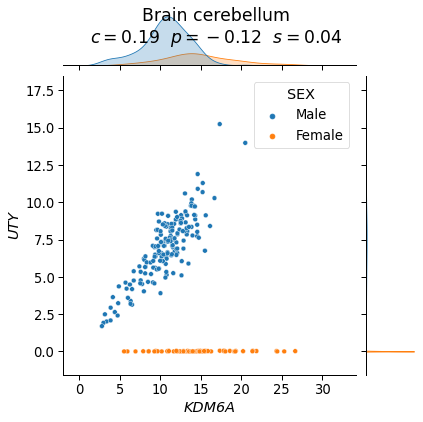

In [56]:
_tissue_data = plot_gene_pair(
    "brain_cerebellum",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
    samples=None,
    filename_suffix="-all",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_brain_cerebellum-KDM6A_vs_UTY-males.svg')

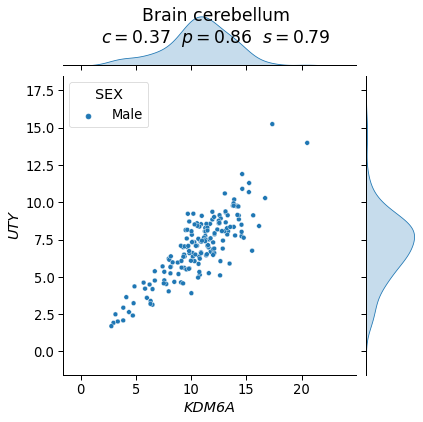

In [57]:
_tissue_data = plot_gene_pair(
    "brain_cerebellum",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
    samples=male_samples,
    filename_suffix="-males",
)

## Smalle intestine (males)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_small_intestine_terminal_ileum-KDM6A_vs_UTY-all.svg')

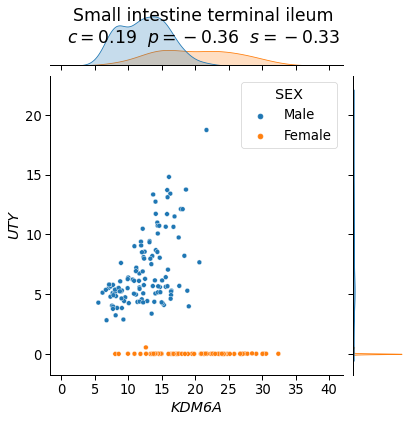

In [58]:
_tissue_data = plot_gene_pair(
    "small_intestine_terminal_ileum",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
    samples=None,
    filename_suffix="-all",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_small_intestine_terminal_ileum-KDM6A_vs_UTY-males.svg')

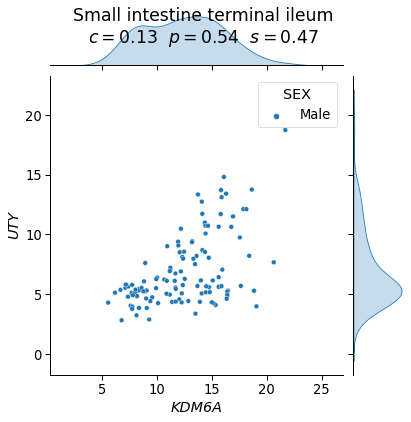

In [59]:
_tissue_data = plot_gene_pair(
    "small_intestine_terminal_ileum",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
    samples=male_samples,
    filename_suffix="-males",
)

# Understand how CCC divides samples

## Prepare datasets

In [70]:
datasets_df = pd.DataFrame(
    {
        "dataset": "Brain cerebellum\n(males + females)",
        gene0_symbol: brain_cerebellum.iloc[:, 0],
        gene1_symbol: brain_cerebellum.iloc[:, 1],
    }
)

datasets_df = datasets_df.append(
    pd.DataFrame(
        {
            "dataset": "Small intestine (terminal ileum)\n(males + females)",
            gene0_symbol: small_intestine.iloc[:, 0],
            gene1_symbol: small_intestine.iloc[:, 1],
        }
    ),
    ignore_index=True,
)

datasets_df = datasets_df.append(
    pd.DataFrame(
        {
            "dataset": "Brain cerebellum\n(males)",
            gene0_symbol: brain_cerebellum_males.iloc[:, 0],
            gene1_symbol: brain_cerebellum_males.iloc[:, 1],
        }
    ),
    ignore_index=True,
)

datasets_df = datasets_df.append(
    pd.DataFrame(
        {
            "dataset": "Small intestine (terminal ileum)\n(males)",
            gene0_symbol: small_intestine_males.iloc[:, 0],
            gene1_symbol: small_intestine_males.iloc[:, 1],
        }
    ),
    ignore_index=True,
)

In [71]:
datasets = {
    idx: df.drop(columns="dataset") for idx, df in datasets_df.groupby("dataset")
}

In [72]:
def get_cm_line_points(x, y, max_parts, parts):
    """
    Given two data vectors (x and y) and the max_parts and parts
    returned from calling cm, this function returns two arrays with
    scalars to draw the lines that separates clusters in x and y.
    """
    # get the ccc partitions that maximize the coefficient
    x_max_part = parts[0][max_parts[0]]
    x_unique_k = {}
    for k in np.unique(x_max_part):
        data = x[x_max_part == k]
        x_unique_k[k] = data.min(), data.max()
    x_unique_k = sorted(x_unique_k.items(), key=lambda x: x[1][0])

    y_max_part = parts[1][max_parts[1]]
    y_unique_k = {}
    for k in np.unique(y_max_part):
        data = y[y_max_part == k]
        y_unique_k[k] = data.min(), data.max()
    y_unique_k = sorted(y_unique_k.items(), key=lambda x: x[1][0])

    x_line_points, y_line_points = [], []

    for idx in range(len(x_unique_k) - 1):
        k, (k_min, k_max) = x_unique_k[idx]
        nk, (nk_min, nk_max) = x_unique_k[idx + 1]

        x_line_points.append((k_max + nk_min) / 2.0)

    for idx in range(len(y_unique_k) - 1):
        k, (k_min, k_max) = y_unique_k[idx]
        nk, (nk_min, nk_max) = y_unique_k[idx + 1]

        y_line_points.append((k_max + nk_min) / 2.0)

    return x_line_points, y_line_points

## Brain cerebellum and Small intestine (males)

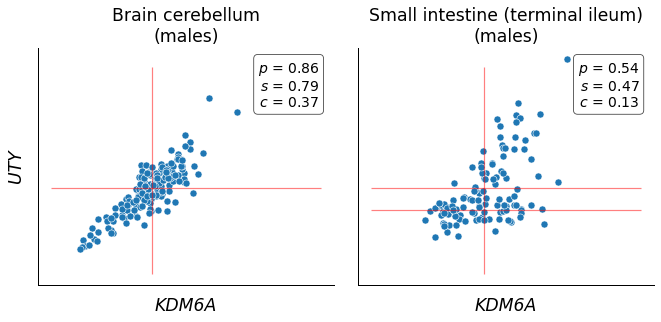

In [76]:
with sns.plotting_context("paper", font_scale=1.8):
    g = sns.FacetGrid(
        data=datasets_df,
        col="dataset",
        col_order=[
            # "Brain cerebellum (all)",
            # "Small intestine (terminal ileum) (all)",
            "Brain cerebellum\n(males)",
            "Small intestine (terminal ileum)\n(males)",
        ],
        col_wrap=2,
        height=5,
    )
    g.map(sns.scatterplot, gene0_symbol, gene1_symbol, s=50, alpha=1)
    g.set_titles(row_template="{row_name}", col_template="{col_name}")

    for ds, ax in g.axes_dict.items():
        df = datasets[ds].to_numpy()
        x, y = df[:, 0], df[:, 1]

        # pearson and spearman
        r = pearsonr(x, y)[0]
        rs = spearmanr(x, y)[0]

        # ccc
        c, max_parts, parts = ccc(x, y, return_parts=True)
        c = ccc(x, y)

        x_line_points, y_line_points = get_cm_line_points(x, y, max_parts, parts)
        for yp in y_line_points:
            ax.hlines(y=yp, xmin=-0.5, xmax=30, color="r", alpha=0.5)

        for xp in x_line_points:
            ax.vlines(x=xp, ymin=-0.5, ymax=18, color="r", alpha=0.5)

        # add text box for the statistics
        stats = (
            f"$\it{{p}}$ ={r: .2f}\n"
            f"$\it{{s}}$ ={rs: .2f}\n"
            f"$\it{{c}}$ ={c: .2f}"
        )
        # stats = f"$c$ = {c:.2f}"
        bbox = dict(boxstyle="round", fc="white", ec="black", alpha=0.75)
        ax.text(
            0.95,
            0.75,
            stats,
            fontsize=14,
            bbox=bbox,
            transform=ax.transAxes,
            horizontalalignment="right",
        )
        ax.set_xlabel(f"{gene0_symbol}", fontstyle="italic")
        ax.set_ylabel(f"{gene1_symbol}", fontstyle="italic")
        ax.set(xticklabels=[], yticklabels=[])
        ax.tick_params(left=False, bottom=False)

    plt.savefig(
        OUTPUT_FIGURE_DIR
        / "gtex_brain_cerebellum_and_small_intestine_terminal_ileum-KDM6A_vs_UTY-males.svg",
        # rasterized=True,
        dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )

## Plot

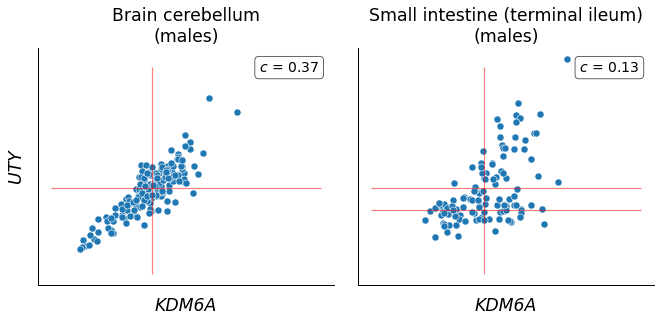

In [74]:
with sns.plotting_context("paper", font_scale=1.8):
    g = sns.FacetGrid(
        data=datasets_df,
        col="dataset",
        col_order=[
            # "Brain cerebellum (all)",
            # "Small intestine (terminal ileum) (all)",
            "Brain cerebellum\n(males)",
            "Small intestine (terminal ileum)\n(males)",
        ],
        col_wrap=2,
        height=5,
    )
    g.map(sns.scatterplot, gene0_symbol, gene1_symbol, s=50, alpha=1)
    g.set_titles(row_template="{row_name}", col_template="{col_name}")

    for ds, ax in g.axes_dict.items():
        df = datasets[ds].to_numpy()
        x, y = df[:, 0], df[:, 1]

        # pearson and spearman
        r = pearsonr(x, y)[0]
        rs = spearmanr(x, y)[0]

        # ccc
        c, max_parts, parts = ccc(x, y, return_parts=True)
        c = ccc(x, y)

        x_line_points, y_line_points = get_cm_line_points(x, y, max_parts, parts)
        for yp in y_line_points:
            ax.hlines(y=yp, xmin=-0.5, xmax=30, color="r", alpha=0.5)

        for xp in x_line_points:
            ax.vlines(x=xp, ymin=-0.5, ymax=18, color="r", alpha=0.5)

        # add text box for the statistics
        stats = f"$c$ = {c:.2f}"
        bbox = dict(boxstyle="round", fc="white", ec="black", alpha=0.75)
        ax.text(
            0.95,
            0.90,
            stats,
            fontsize=14,
            bbox=bbox,
            transform=ax.transAxes,
            horizontalalignment="right",
        )
        ax.set_xlabel(f"{gene0_symbol}", fontstyle="italic")
        ax.set_ylabel(f"{gene1_symbol}", fontstyle="italic")
        ax.set(xticklabels=[], yticklabels=[])
        ax.tick_params(left=False, bottom=False)

    plt.savefig(
        OUTPUT_FIGURE_DIR
        / "gtex-KDM6A_vs_UTY-brain_cerebellum_and_small_intestine_terminal_ileum-clusters-males.svg",
        # rasterized=True,
        dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )

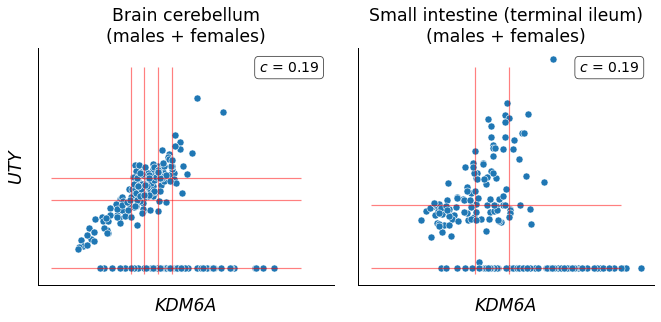

In [75]:
with sns.plotting_context("paper", font_scale=1.8):
    g = sns.FacetGrid(
        data=datasets_df,
        col="dataset",
        col_order=[
            "Brain cerebellum\n(males + females)",
            "Small intestine (terminal ileum)\n(males + females)",
            # "Brain cerebellum (males)",
            # "Small intestine (terminal ileum) (males)",
        ],
        col_wrap=2,
        height=5,
    )
    g.map(sns.scatterplot, gene0_symbol, gene1_symbol, s=50, alpha=1)
    g.set_titles(row_template="{row_name}", col_template="{col_name}")

    for ds, ax in g.axes_dict.items():
        df = datasets[ds].to_numpy()
        x, y = df[:, 0], df[:, 1]

        # pearson and spearman
        r = pearsonr(x, y)[0]
        rs = spearmanr(x, y)[0]

        # ccc
        c, max_parts, parts = ccc(x, y, return_parts=True)
        c = ccc(x, y)

        x_line_points, y_line_points = get_cm_line_points(x, y, max_parts, parts)
        for yp in y_line_points:
            ax.hlines(y=yp, xmin=-0.5, xmax=30, color="r", alpha=0.5)

        for xp in x_line_points:
            ax.vlines(x=xp, ymin=-0.5, ymax=18, color="r", alpha=0.5)

        # add text box for the statistics
        stats = f"$c$ = {c:.2f}"
        bbox = dict(boxstyle="round", fc="white", ec="black", alpha=0.75)
        ax.text(
            0.95,
            0.90,
            stats,
            fontsize=14,
            bbox=bbox,
            transform=ax.transAxes,
            horizontalalignment="right",
        )
        ax.set_xlabel(f"{gene0_symbol}", fontstyle="italic")
        ax.set_ylabel(f"{gene1_symbol}", fontstyle="italic")
        ax.set(xticklabels=[], yticklabels=[])
        ax.tick_params(left=False, bottom=False)

    plt.savefig(
        OUTPUT_FIGURE_DIR
        / "gtex-KDM6A_vs_UTY-brain_cerebellum_and_small_intestine_terminal_ileum-clusters-all.svg",
        # rasterized=True,
        dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )

# Create final figure

In [68]:
from svgutils.compose import Figure, SVG, Panel, Text

In [80]:
Figure(
    f"{60.0767480 * 6}cm",
    f"{60.0767480 * 6}cm",
    # Panel(
    #     SVG(OUTPUT_FIGURE_DIR / "gtex_brain_cerebellum_and_small_intestine_terminal_ileum-KDM6A_vs_UTY-males.svg").scale(0.5),
    #     Text("a)", 2, 10, size=9, weight="bold"),
    # ),
    Panel(
        SVG(OUTPUT_FIGURE_DIR / "gtex_brain_cerebellum_and_small_intestine_terminal_ileum-KDM6A_vs_UTY-males.svg").scale(0.5),
        Text("a)", 2, 10, size=9, weight="bold"),
    ),#.move(0, 180),
    Panel(
        SVG(OUTPUT_FIGURE_DIR / "gtex-KDM6A_vs_UTY-brain_cerebellum_and_small_intestine_terminal_ileum-clusters-all.svg").scale(0.5),
        Text("b)", 2, 10, size=9, weight="bold"),
    ).move(0, 170),#.move(0, 180+170),
).save(OUTPUT_FIGURE_DIR / "gtex-KDM6A_vs_UTY-nonlinear_and_linear.svg")

Now open the final file, reside to fit drawing to page, and add a white rectangle to the background.